# K-Nearest Neighbors Classification of Digits

Purpose: Use Numpy to implement a K-nearest neighbors classifier, here on out referred as KNN. 

Format of Data: 
MNIST Dataset. Dataset of images of handwirtten digits. 

- Format: png
- Samples: 60, 000 images 
- Channels: 1
- Size: 28 x 28

Pixel values, at least for the first image is already going from 0 to 1.

**Preprocessing:**

Normalize pixel values to [0,1] (NumPy) or [-1,1] (PyTorch with transforms.Normalize).

Flatten into vectors (784 features) when needed.

Keep 2D shape for CNNs.


In [1]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from collections import Counter
import os

In [ ]:
# read all images
# ai suggested to use os.scandir to read each file in a directory


# load all images into a numopy array then save it
categories = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
array_path = os.path.exists("images_array.npy")
labels_path = os.path.exists("labels_array.npy")

if (not array_path):
    data = np.zeros()
    data = np.zeros(shape=(60_000, 28, 28))
    labels = np.zeros(shape=(data.shape[0]))


    root = "MNIST"
    img_idx = 0

    for cat in categories:
        path = os.path.join(root, cat)
        for entry in os.scandir(path):
            file_path = entry.path
            img = mpimg.imread(file_path).flatten() # save flattened array
            data[img_idx, :] = img
            labels[img_idx] = int(cat)

            img_idx += 1


    np.save(r"images_array.npy", data)
    np.save(r"labels_array.npy", labels)

else:
    data = np.load("images_array.npy")
    labels = np.load("labels_array.npy")
        

        

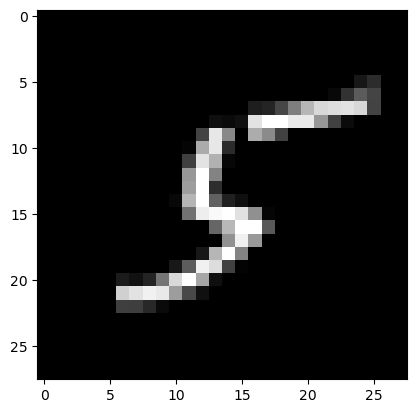

In [3]:
test = data[35000].reshape(28, 28)
plt.imshow(test, cmap='grey')

In [ ]:
def train_test_split(dataset, dataset_labels, train_size = None, test_size = None):
    """
    Function to create train test splits in with shuffling. The behavior of the function given the
    arguments passed to the function for the train and test size are inspired by the behavior of
    scikitlearn's train_test_split function.
    """
    # this function assumes each row is a sample

    # Set size of training and test test if not fully given.
    if (train_size is None and test_size is None):
        train_size = 0.8
        test_size = 0.2
    elif (train_size is None and isinstance(test_size, float)):
        train_size = 1 - test_size
    elif (isinstance(train_size, float) and test_size is None):
        test_size = 1 - train_size
    
    if (train_size + test_size != 1):
        print("invalid train/test split size")
        return

    # Find how many elements the resulting arrays will have after the split    
    test_length = int(test_size * dataset.shape[0])
    indices = np.random.randint(0, dataset.shape[0], size = (test_length))
    # Use random indices to sample from the dataset
    x_test = dataset[indices]
    y_test = dataset_labels[indices] # labels of test data
    # Get train data
    # use a mask to get the elements not present in the testing sets
    mask = ~np.isin(np.array([x for x in range(dataset.shape[0])]), indices)
    x_train = dataset[mask]
    y_train = dataset_labels[mask] # labels of training data

    return  x_train, y_train, x_test, y_test




    

Explanation of _multi_dist function:
This function will calculate a measure of distance from multiple samples to multiple other samples. Typically, in KNN, the euclidian distance is used. However, in our case we don't need to go the last step of taking the squared root of the sum of the differences squared. By being able to calculate the distance of multiple samples to multiple other samples we are making a more efficient calculation than if we had to compute the distance from one sample to all other samples and then do that for each sample in our test set.

Initially i followed this approach, until a classmate directed me to the following video: https://www.youtube.com/watch?v=2guuT2wsl9Q

Although i didnt't watch the video, I saw a different expression for calculating the distance which involved expanding the terms $(x_i - y_i)^2$ and this expansion seemed to suggest there was a way to more efficiently calculate the distance of samples in the test set to all the samples in the train set.

The idea is that we have our test and train set. Suppose that:
 test set shape is $(10, 784)$

 train set shape is $(50, 784)$ 

 Which is to say we have 10 samples of 784 features in our test set, and 50 samples of 784 features on our train set.
 For simplicity, let's take the transpose of the train set and name it $B$ and name the test set $A$

$A = TestSet, B = TrainSet^T $

And we want to end up with a matrix $C$ of shape $(10, 50)$ where each entry contrains the distance of one sample in the test set to a sample in the training set. 

The first element of the first row would be:

$c_{11} = \sum_{j=1}(a_{1j} - b_{ji})^2$

Generalizing to get all the elements of the first row:
$S_{k=1}\sum_{j=1}(a_{1j} - b_{jk})^2$

Generalizing to get all the elements of all the rows:
$S_{i=1}S_{k=1}\sum_{j=1}(a_{ij} - b_{jk})^2$

When we expand the expression, the first term $\sum_{j}(a_{1j})^2$

Corresponds to the sum over the columns of the squared terms of the first row in $A$, The term 
$\sum_j






In [ ]:
class KNN_Classifier():
    def __init__(self, k = 1):
        self.k = k
        self.predictions = None


    #function to compute the distance for multiple points
    def _multi_dist(self, arr1, arr2):
        """
        Compute the distance of multiple points in one array to multiple points in another.
        """
        # if arr1 is of shape nxm and arr2 of shape m x p
        # we want to end up with an array n x p where each entry is the distance of arr1[0] to arr2[:, 0]
        # Note: it is not necessary to compute the sqrt of the sum of the squared differences
        arr1_sqr = arr1**2
        arr1_sqr = np.sum(arr1_sqr, axis=1).reshape(-1, 1) # sum over the columns, resulting shape n x 1
        arr2_sqr = arr2**2
        arr2_sqr = np.sum(arr2_sqr, axis=0).reshape(1, -1) # resulting shape 1 x p
        multiplication = -2*(arr1 @ arr2)

        # arr1 and arr2 will be broadcasted into the appropriate shapes to put the operation together
        distances = multiplication + arr1_sqr
        distances += arr2_sqr

        return distances
    
    # KNN for multiple points 
    def _predict(self, points, dataset, dataset_labels, k):
        dist = self._multi_dist(points, dataset)   # distance calculation
        
        
        # sort the distances by index to find which are the closest ones
        argsorted_dist = np.argsort(dist, axis = 1)

        predicted = np.zeros(shape=(points.shape[0])) # store the predictions of the labels
        # take a majority vote depending on how many neighbors are being considered
        nearest_neighbors = argsorted_dist[:, :k]
        for i in range(nearest_neighbors.shape[0]): # for each row in the 2d array of the indices of nearest neighbors
            row = dataset_labels[nearest_neighbors[i]]
            c = Counter(row) # count how many of each label we have
            # then get the one that appears the most
            majority = c.most_common()[0][0] # ai suggested to use this function to get the most common label
            predicted[i] = majority
        return predicted
    

    def fit(self, x_test, x_train, y_train):
        self.predictions = self._predict(x_test, x_train, y_train, k = self.k)
        

    def evaluate(self, y_test):
        # Compare predictions to the actual labels
        return np.sum(self.predictions == y_test) / y_test.size





In [ ]:
xtrain, ytrain, xtest, ytest = train_test_split(data, labels, 0.95, 0.05)

In [157]:
knn_classifier = KNN_Classifier(k = 3)
knn_classifier.fit(xtest, xtrain.T, ytrain)
knn_classifier.evaluate(ytest)

np.float64(0.977)